## __Import__

In [2]:
import sys
import os
import pandas as pd
import numpy as np
from ast import literal_eval
from mplsoccer import Pitch, VerticalPitch, Standardizer
# Run the notebook from inside the notebooks folder
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '..')))
from scripts.dataloader import Dataloader

dataloader = Dataloader()
df = dataloader.get_dimension(dimension="possession")
df.columns

# load standard stats
standard_stats = pd.read_csv("../../data/standard_stats.csv").loc[:,["player","full_match_equivalents"]]

[2025-03-28 11:37:17] Loading data form local file system


## __Setting types__

In [4]:
def convert_to_list(input_data):
    if(isinstance(input_data, str)):
        try:
            return literal_eval(input_data)
        except (ValueError, SyntaxError):
            print(f"Error: The string {input_data} could not be converted to a list.")
            return None
    
    return input_data
    
df["location"] = df["location"].apply(convert_to_list)
df["carry_end_location"] = df["carry_end_location"].apply(convert_to_list)
df[["x", "y"]] = df["location"].apply(pd.Series)
df[["x_end_carry", "y_end_carry"]] = df["carry_end_location"].apply(pd.Series)

df["under_pressure"] = df['under_pressure'].fillna(False)
df

,player,type,duration,location,under_pressure,carry_end_location,dribble_nutmeg,dribble_no_touch,dribble_outcome,dribble_overrun,...,counterpress,ball_receipt_outcome,foul_won_penalty,miscontrol_aerial_won,pass_angle,pass_end_location,x,y,x_end_carry,y_end_carry
6,Mark Uth,Pass,0.453238,"[61.0, 40.1]",False,NaN,<NA>,<NA>,NaN,<NA>,...,<NA>,NaN,<NA>,<NA>,-1.919567,"[60.2, 37.9]",61.0,40.1,NaN,NaN
7,Andrej Kramarić,Pass,1.151865,"[59.4, 38.3]",False,NaN,<NA>,<NA>,NaN,<NA>,...,<NA>,NaN,<NA>,<NA>,2.536994,"[53.9, 42.1]",59.4,38.3,NaN,NaN
8,Sebastian Rudy,Pass,1.389406,"[52.3, 45.2]",False,NaN,<NA>,<NA>,NaN,<NA>,...,<NA>,NaN,<NA>,<NA>,2.390664,"[34.3, 62.0]",52.3,45.2,NaN,NaN
9,Fabian Lukas Schär,Pass,2.557696,"[34.3, 61.9]",False,NaN,<NA>,<NA>,NaN,<NA>,...,<NA>,NaN,<NA>,<NA>,-1.487222,"[37.5, 23.7]",34.3,61.9,NaN,NaN
10,Tobias Strobl,Pass,1.417774,"[38.5, 22.2]",False,NaN,<NA>,<NA>,NaN,<NA>,...,<NA>,NaN,<NA>,<NA>,1.705317,"[36.7, 35.5]",38.5,22.2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069827,Douglas Costa de Souza,Dribble,0.000000,"[97.7, 64.7]",True,NaN,<NA>,<NA>,Incomplete,<NA>,...,<NA>,NaN,<NA>,<NA>,NaN,NaN,97.7,64.7,NaN,NaN
1069828,Mario Götze,Dribble,0.000000,"[86.6, 11.9]",True,NaN,<NA>,<NA>,Complete,<NA>,...,<NA>,NaN,<NA>,<NA>,NaN,NaN,86.6,11.9,NaN,NaN
1069829,Mario Götze,Dribble,0.000000,"[61.9, 22.7]",True,NaN,True,<NA>,Complete,<NA>,...,<NA>,NaN,<NA>,<NA>,NaN,NaN,61.9,22.7,NaN,NaN
1069830,Márcio Rafael Ferreira de Souza,Dribble,0.000000,"[98.2, 71.6]",True,NaN,<NA>,<NA>,Incomplete,<NA>,...,<NA>,NaN,<NA>,<NA>,NaN,NaN,98.2,71.6,NaN,NaN


## __Generate Features__

In [8]:
def is_in_penalty_area(x, y):
    pitch_width = 120
    x_axis = ((102 <= x) and (x <= pitch_width))  # Stop before goal area
    y_axis = ((40 - 22) <= y and y <= (40 + 22))
    return x_axis and y_axis

def is_in_defensive_penalty_area(x, y):
    x_axis = ((0 <= x) and (x <= 18))  # Stop before goal area
    y_axis = ((40 - 22) <= y and y <= (40 + 22))
    return x_axis and y_axis

def is_in_edge_of_the_box(x,y):
    pitch_width = 120
    x_axis = ((102 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis

def get_shot_distance(x_start,y_start,x_end,y_end):
    #print("Executing is_short_distance_shot method")

    start = np.array([x_start, y_start])
    end = np.array([x_end, y_end])

    return np.linalg.norm(start - end)

def is_progressive_carry(start_x, start_y, end_x, end_y):
    """
    Check if a carry is progressive towards the goal area.
    
    A carry is progressive if the end position is closer to the goal area than the start position.
    
    Args:
        start_x (float): x-coordinate of the carry start position
        start_y (float): y-coordinate of the carry start position
        end_x (float): x-coordinate of the carry end position
        end_y (float): y-coordinate of the carry end position
        pitch_width (float): width of the pitch
        
    Returns:
        bool: True if the carry is progressive, False otherwise
    """
    goal_center_x = 120
    goal_center_y = 40
    
    # Calculate distances from start and end points to the goal center
    start_distance = ((start_x - goal_center_x) ** 2 + (start_y - goal_center_y) ** 2) ** 0.5
    end_distance = ((end_x - goal_center_x) ** 2 + (end_y - goal_center_y) ** 2) ** 0.5
    
    # A carry is progressive if the end point is closer to the goal center than the start point
    return end_distance < start_distance


def analyze_touches(df, standard_stats):
    """
    This function Pre-compute all conditions for Vectorize operations.
    Returns results grouped by player and under_pressure  
    """
    # Pre-compute all conditions
    df_with_flags = df.copy()

    # Location-based flags
    df_with_flags['is_attacking_third'] = df['x'] >= 80
    df_with_flags['is_middle_third'] = (80 > df['x']) & (df['x'] > 40)
    df_with_flags['is_defending_third'] = df['x'] <= 40
    df_with_flags['is_in_box'] = df[["x","y"]].apply(lambda row: is_in_penalty_area(row['x'], row['y']), axis=1)
    df_with_flags['is_in_edge_box'] = df[["x","y"]].apply(lambda row: is_in_edge_of_the_box(row['x'], row['y']), axis=1)
    df_with_flags['is_in_defending_box'] = df[["x","y"]].apply(lambda row: is_in_defensive_penalty_area(row['x'], row['y']), axis=1)
    df_with_flags['ends_attacking_third'] = df['x_end_carry'] >= 80
    df_with_flags['ends_in_box'] = df[['x_end_carry','y_end_carry']].apply(lambda row: is_in_penalty_area(row['x_end_carry'], row['y_end_carry']), axis=1)
    df_with_flags['ends_in_edge_box'] = df[['x_end_carry','y_end_carry']].apply(lambda row: is_in_edge_of_the_box(row['x_end_carry'], row['y_end_carry']), axis=1)
    df_with_flags["carry_distance"] = np.sqrt((df["x_end_carry"] - df["x"])**2 + (df["y_end_carry"] - df["y"])**2)
    

    # Check if progressive carry
    df_with_flags["start_to_goal_distance"] = np.sqrt( (df["x"] - 120)**2 + (df["y"] - 40)**2)
    df_with_flags["end_to_goal_distance"] = np.sqrt((df["x_end_carry"] - 120)**2 + (df["y_end_carry"] - 40)**2)
    df_with_flags["is_progressive_carry"] = df_with_flags["end_to_goal_distance"] < df_with_flags["start_to_goal_distance"]


    # Action flags
    df_with_flags['is_dribbling'] = df['type'] == "Dribble"
    df_with_flags['is_overrun'] = df['dribble_overrun'] == True
    df_with_flags['is_nutmeg'] = df['dribble_nutmeg'] == True
    df_with_flags['is_no_touch'] = df['dribble_no_touch'] == True
    df_with_flags['is_carry'] = df['type'] == "Carry"
    df_with_flags['is_touch'] = (df['type'] != "Dispossessed") & (df['type'] != "Error")
    df_with_flags['is_miscontrol'] = df['type'] == "Miscontrol"
    df_with_flags['is_miscontrol_in_aerial_duel'] = df['miscontrol_aerial_won'] == True
    df_with_flags['is_dispossessed'] =  df["type"]=='Dispossessed' # (df['duel_outcome'] == "Lost") | (df['duel_outcome'] == "Lost In Play") | (df['duel_outcome'] == "Lost Out")
    df_with_flags['balls_received'] = df["type"]=='Ball Receipt*'
    df_with_flags['balls_received_successful'] = (df_with_flags['balls_received']) & (df["ball_receipt_outcome"].isna())
    df_with_flags['is_error'] = df["type"]=='Error'
    df_with_flags['is_offside'] = df["type"]=='Offside'

    # Combination of flags
    df_with_flags['is_dribbling_and_completed'] = df_with_flags['is_dribbling'] & (df["dribble_outcome"] == "Complete")
    df_with_flags['is_dribbling_and_is_not_completed'] = df_with_flags['is_dribbling'] & (df["dribble_outcome"] == "Incomplete")
    df_with_flags['is_dribbling_and_overrun'] = df_with_flags['is_dribbling'] & (df_with_flags['is_overrun'])
    df_with_flags['is_dribbling_and_through_legs'] = df_with_flags['is_dribbling'] & (df_with_flags['is_nutmeg'])
    df_with_flags['is_dribbling_and_no_touch'] = df_with_flags['is_dribbling'] & (df_with_flags['is_no_touch'])
    df_with_flags['is_carry_from_outside_inside_attacking_third'] = (~df_with_flags['is_attacking_third']) & (df_with_flags['ends_attacking_third'])
    df_with_flags['is_carry_from_outside_inside_penalty_area'] = (~df_with_flags['is_in_box']) & (df_with_flags['ends_in_box'])
    df_with_flags['is_carry_from_outside_inside_edge_of_the_box'] = (~df_with_flags['is_in_edge_box']) & (df_with_flags['ends_in_edge_box'])
    df_with_flags['is_dispossessed_in_defending_penalty_area'] = df_with_flags['is_dispossessed'] & df_with_flags['is_in_defending_box']
    df_with_flags['is_dispossessed_in_defending_third'] = df_with_flags['is_dispossessed'] & df_with_flags['is_defending_third']
    df_with_flags['is_dispossessed_in_middle_third'] = df_with_flags['is_dispossessed'] & df_with_flags['is_middle_third']
    df_with_flags['is_dispossessed_in_attacking_third'] = df_with_flags['is_dispossessed'] & df_with_flags['is_attacking_third']
    df_with_flags['is_dispossessed_in_penalty_area'] = df_with_flags['is_dispossessed'] & df_with_flags['is_in_box']


    player_under_pressure_grouping = df_with_flags.groupby(['player', 'under_pressure']).agg(
        # touches
        touches_total=('is_touch', 'count'),
        touches_in_defending_penalty=("is_in_defending_box", "sum"),
        touches_in_defending_third=("is_defending_third", "sum"),
        touches_in_middle_third=("is_middle_third", "sum"),
        touches_in_attacking_third=("is_attacking_third", "sum"),
        touches_in_attacking_penalty=("is_in_box", "sum"),
        # dribblings
        dribbling_total=("is_dribbling", "sum"),
        dribbling_completed=("is_dribbling_and_completed", "sum"),
        dribbling_not_completed=("is_dribbling_and_is_not_completed", "sum"),
        dribbling_overrun=("is_dribbling_and_overrun", "sum"),
        dribbling_through_legs=("is_dribbling_and_through_legs", "sum"),
        dribbling_push_and_run=("is_dribbling_and_no_touch", "sum"),
        # carries
        carries_total=("is_carry","sum"),
        carry_into_attacking_third=("is_carry_from_outside_inside_attacking_third","sum"),
        carry_into_penalty_area=("is_carry_from_outside_inside_penalty_area","sum"),
        carry_into_edge_of_the_box=("is_carry_from_outside_inside_edge_of_the_box","sum"),
        carry_distance=("carry_distance", "sum"),
        # progressive carries
        progressive_carry_total=("is_progressive_carry","sum"),
        progressive_carry_distance=("carry_distance", lambda x: x[df_with_flags["is_progressive_carry"]].sum()),
        # miscontrols and dispossesions
        miscontrol_total=("is_miscontrol","sum"),
        miscontrol_in_aerial_duel=("is_miscontrol_in_aerial_duel", "sum"),
        dispossessed_total=("is_dispossessed", "sum"),
        dispossessed_in_defending_penalty_area=("is_dispossessed_in_defending_penalty_area", "sum"),
        dispossessed_in_defending_third=("is_dispossessed_in_defending_third", "sum"),
        dispossessed_in_middle_third=("is_dispossessed_in_middle_third", "sum"),
        dispossessed_in_attacking_third=("is_dispossessed_in_attacking_third", "sum"),
        dispossessed_in_penalty_area=("is_dispossessed_in_penalty_area", "sum"),
        # ball receive
        balls_received=("balls_received", "sum"),
        balls_received_successful=("balls_received_successful","sum"),
        # error an offside
        error_lead_to_goal=("is_error","sum"),
        offside=("is_offside", "sum")
    )

    total_stats = player_under_pressure_grouping.groupby('player').sum()
    player_under_pressure_grouping = player_under_pressure_grouping.add_prefix('up_')
    player_under_pressure_grouping = player_under_pressure_grouping.reset_index()
    player_under_pressure_grouping = player_under_pressure_grouping[player_under_pressure_grouping["under_pressure"] == True]
    player_under_pressure_grouping = player_under_pressure_grouping.drop("under_pressure", axis=1)

    player_stats = pd.merge(left=total_stats, right=player_under_pressure_grouping, on="player")

    ### calculate relative values ###

    calculation_pairs = [
        ("touches_in_defending_penalty","touches_total","touches_in_defending_penalty_%"),
        ("touches_in_defending_third","touches_total","touches_in_defending_third_%"),
        ("touches_in_middle_third","touches_total","touches_in_middle_third_%"),
        ("touches_in_attacking_third","touches_total","touches_in_attacking_third_%"),
        ("touches_in_attacking_penalty","touches_total","touches_in_attacking_penalty_%"),
        ("balls_received_successful", "balls_received", "ball_reception_%"),
        ("dribbling_completed", "dribbling_total", "dribblings_successful_%"),
        ("carry_distance", "carries_total", "distance_per_carry_%"),
        ("carry_into_attacking_third","carries_total", "carries_into_attacking_third_%"),
        ("carry_into_penalty_area","carries_total", "carries_into_penalty_area_%"),
        ("carry_into_edge_of_the_box","carries_total", "carries_into_edge_of_the_box_%"),
        ("progressive_carry_distance", "progressive_carry_total", "distance_per_progressive_carry"),
        ("dispossessed_total","carries_total","dispossessed_per_carry_%")
    ]

    for a, b, c in calculation_pairs:
        player_stats[c] = (player_stats[f'{a}'] / player_stats[f'{b}'])
        # replace inf
        player_stats[c] = player_stats[c].replace([np.inf, -np.inf], 0)


    ###  calcuate stats per match ###

    # merge standard stats with absolute values (result_df)
    absolute_column_values = [col for col in player_stats.columns if not col.endswith("_%") ]
    df_stats_per_game = pd.merge(left=standard_stats, right=player_stats[absolute_column_values],on="player",how="left")
    df_stats_per_game = df_stats_per_game.fillna(0)

    # calcuate stats per match and add to result_df
    for col in df_stats_per_game.drop(["player", "full_match_equivalents"], axis=1).columns:
        col_name = f"{col}_per_match"
        df_stats_per_game[col_name] = (df_stats_per_game[col] / 90).round(3)

    # keep only per match stats
    column_per_match = [col for col in df_stats_per_game.columns if col.endswith("_per_match") or col=="player" ]
    df_stats_per_game = df_stats_per_game[column_per_match]

    # merge: abosulte, relative, per game values
    player_stats = pd.merge(left=player_stats, right=df_stats_per_game, on="player", how="right")
    player_stats = player_stats.fillna(0)


    return player_stats

result_touches_df = analyze_touches(df, standard_stats)
result_touches_df

,player,touches_total,touches_in_defending_penalty,touches_in_defending_third,touches_in_middle_third,touches_in_attacking_third,touches_in_attacking_penalty,dribbling_total,dribbling_completed,dribbling_not_completed,...,up_dispossessed_in_defending_penalty_area_per_match,up_dispossessed_in_defending_third_per_match,up_dispossessed_in_middle_third_per_match,up_dispossessed_in_attacking_third_per_match,up_dispossessed_in_penalty_area_per_match,up_balls_received_per_match,up_balls_received_successful_per_match,up_error_lead_to_goal_per_match,up_offside_per_match,distance_per_progressive_carry_per_match
0,Aaron Hunt,3009.0,30.0,308.0,1579.0,1122.0,108.0,37.0,25.0,12.0,...,0.000,0.022,0.156,0.122,0.011,1.011,0.956,0.0,0.0,0.099
1,Adam Hloušek,559.0,24.0,308.0,218.0,33.0,7.0,1.0,1.0,0.0,...,0.000,0.011,0.000,0.000,0.000,0.011,0.011,0.0,0.0,0.086
2,Adelino André Vieira Freitas,4067.0,71.0,675.0,2142.0,1250.0,95.0,37.0,24.0,13.0,...,0.000,0.067,0.111,0.122,0.033,1.111,1.078,0.0,0.0,0.075
3,Admir Mehmedi,2264.0,26.0,202.0,955.0,1107.0,154.0,44.0,32.0,12.0,...,0.000,0.044,0.156,0.256,0.044,1.056,1.011,0.0,0.0,0.089
4,Adnan Januzaj,262.0,0.0,8.0,76.0,178.0,25.0,7.0,5.0,2.0,...,0.000,0.000,0.033,0.067,0.033,0.144,0.133,0.0,0.0,0.111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,Özkan Yıldırım,30.0,0.0,2.0,2.0,26.0,4.0,1.0,0.0,1.0,...,0.000,0.000,0.000,0.000,0.000,0.022,0.022,0.0,0.0,0.084
535,Ørjan Håskjold Nyland,461.0,346.0,459.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.111,0.111,0.0,0.0,0.104
536,İlkay Gündoğan,6274.0,42.0,577.0,4359.0,1338.0,88.0,66.0,48.0,18.0,...,0.011,0.033,0.233,0.100,0.022,1.133,1.111,0.0,0.0,0.075
537,Łukasz Piszczek,3421.0,82.0,677.0,1930.0,814.0,71.0,15.0,9.0,6.0,...,0.000,0.022,0.078,0.056,0.000,0.244,0.233,0.0,0.0,0.078


## __Store Data__

In [9]:
result_touches_df.to_csv("../../data/possession.csv",index=False)

## __Visualize__

KeyError: 'possession_team'

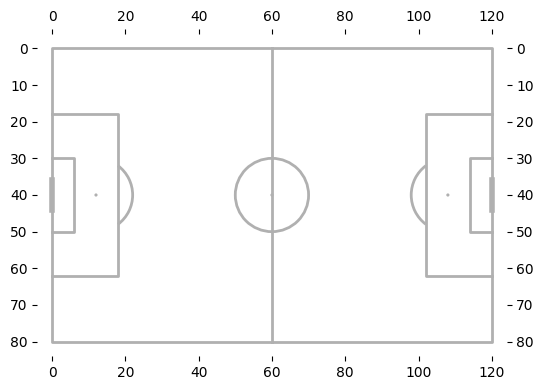

In [13]:
pitch = Pitch(label=True, tick=True)
fig, ax = pitch.draw(figsize=(8, 4))

t = result_touches_df[result_touches_df["possession_team"]=="Schalke 04"]
t1 = result_touches_df[(result_touches_df["possession_team"]=="Schalke 04") & (result_touches_df["period"] == 2) & result_touches_df['ends_attacking_third']]
"""pitch.arrows(
    t1.loc[t1["is_carry"]==True,"x"],t1.loc[t1["is_carry"]==True,"y"],
    t1.loc[t1["is_carry"]==True,"x_end_carry"],t1.loc[t1["is_carry"]==True,"y_end_carry"],
    ax=ax,width=1 ,color='lightblue'

)"""
pitch_width = 120
goal_x_min = pitch_width - 6
goal_x_max = pitch_width
goal_y_min = 40 - 10
goal_y_max = 40 + 10
ax.scatter(120, 40, c='lightblue', s=50, edgecolors='black', zorder=5)
#ax.scatter(result_touches_df.loc[result_touches_df["is_carry"]==True,"x"], result_touches_df.loc[result_touches_df["is_carry"]==True,"y"], c='lightblue', s=50, edgecolors='black', zorder=5)